# Image Measurement in Python
Now that we know a little bit about how images are formed, let's try to make some scientific measurements on things.

Open in [google colab](http://colab.research.google.com/github/jayunruh/python_IP_course/blob/master/image_label_measurements_colab.ipynb)

In [ ]:
#tifffile reads tif's into a multidimensional array
import tifffile
#matplotlib let's us plot data
import matplotlib.pyplot as plt
#pandas handles tables
import pandas as pd
#numpy handles multidimensional data sets
import numpy as np
#scipy ndimage does image filtering and label measurement
import scipy.ndimage as ndi
#requests lets us get image data from a github url
import requests
#io converts that data to bytes like from a file
import io

In [ ]:
#this little function gets image bytes from a url (like github)
def getGitHubImage(url):
  return io.BytesIO(requests.get(url).content)

To start off, let's label our blobs from last lesson and measure them.  We will start by making a black and white image with white indicating the blobs.

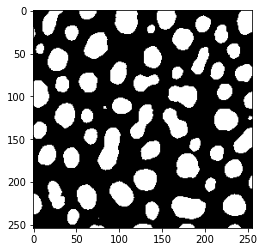

In [ ]:
#img=tifffile.imread('blobs.tif')
blobsurl='https://github.com/jayunruh/python_IP_course/raw/master/blobs.tif'
img=tifffile.imread(getGitHubImage(blobsurl))
mask=img>128
plt.imshow(mask,cmap='gray')

To label our blobs, use the ndimage label tool.

In [ ]:
labels,nblobs=ndi.label(mask)
nblobs

63

The algorithm found 63 blobs in our image.  Let's see what the labels array looks like.

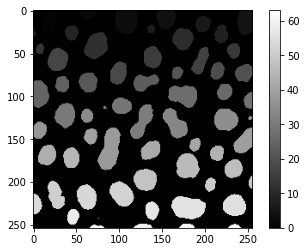

In [ ]:
plt.imshow(labels,cmap='gray')
plt.colorbar()
plt.show()

This kind of image processing is called segmentation.  So the labels array is just an image matrix with each blob colored by it's order of discovery.  We want to get the size distribution of blobs.  But watch out!  We can't get the right size for the blobs on the edge.  How would we find which blobs are on the edge?  We can make an array from all the different edges and find out which label values are in that array.

Since you haven't spent much time working with numpy yet, we'll gloss over some things here but I want to explain a bit.  You can slice a numpy array along any dimension with array[ystart:yend,xstart:xend].  Note that these slices go from start to end-1.  If you use -1 when slicing an array, that is code for "the last value in the array".  So array[1:-1] goes from the second array element to the second to last array element.  Numpy arrays can't do some of the things that python lists can do, so you can convert a numpy array into a list with the list(arr) command.

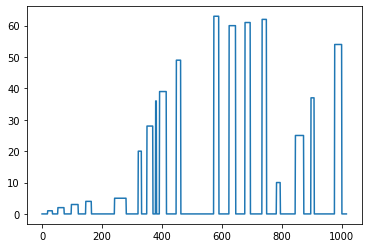

In [ ]:
#make an array out of the upper edge, the right edge, the bottom edge, and the left edge
#order doesn't matter here because we're just accounting for values
edgearray=list(labels[0,:-1])+list(labels[:-1,-1])+list(labels[-1,1:])+list(labels[1:,0])
plt.plot(edgearray)

We can find the unique values in this array with the Numpy unique command.

In [ ]:
edgelabels=np.unique(edgearray)
edgelabels

array([ 0,  1,  2,  3,  4,  5, 10, 20, 25, 28, 36, 37, 39, 49, 54, 60, 61,
       62, 63], dtype=int32)

Now that we have our edge values, we can delete them from the labels image (omitting zero).

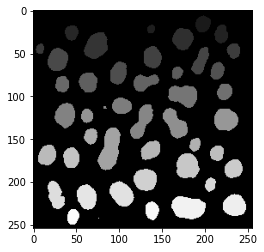

In [ ]:
filtered=labels.copy()
for idx in edgelabels[1:]:
    filtered[labels==idx]=0.0
plt.imshow(filtered,cmap='gray')

By the way, now we know how to filter our labels as well--just make a list of the ones we want to delete and set them to 0.  Note that we haven't renumbered our objects, so those will be missing when we measure things.  Just to make things easy, let's refind our labels to get them numbered right.

In [ ]:
filtered,filtblobs=ndi.label(filtered>0)
filtblobs

45

Now let's get some measurements.  Typical ones we will want are average, sum, and size (area).  For this we can use the ndimage mean and sum functions.

In [ ]:
#start with the sum--this takes 3 arguments: the image we want to measure, the labels image,
#and the list of labels we want to measure--since our labels go from 0 to filtblobs, we can use range for this
labelsums=ndi.sum(img,filtered,range(1,filtblobs+1))

Let's histogram these values.  I'm not going to go into how the histogram works but it's fairly self explanatory.

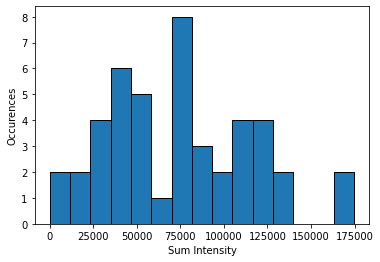

In [ ]:
plt.hist(labelsums,bins=15,edgecolor='black')
plt.xlabel('Sum Intensity')
plt.ylabel('Occurences')
plt.show()

We have a wide range of intensities here but that could be because we have a wide range of label sizes.  Maybe mean will eliminate this dependence.

In [ ]:
labelavgs=ndi.mean(img,filtered,range(1,filtblobs+1))

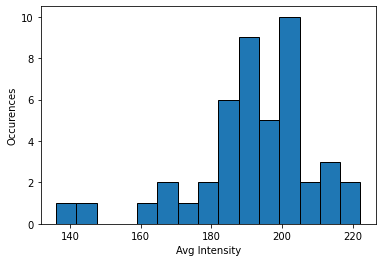

In [ ]:
plt.hist(labelavgs,bins=15,edgecolor='black')
plt.xlabel('Avg Intensity')
plt.ylabel('Occurences')
plt.show()

As we thought, the heterogeneity is largely caused by the label size and the mean is much narrower.  Let's see about the area distribution.  Note that there isn't an explicit way to measure area but if we measure an image filled with ones the sum will give us the area.  The Numpy ones command will give us such an image.

In [ ]:
labelareas=ndi.sum(np.ones(img.shape),filtered,range(1,filtblobs+1))

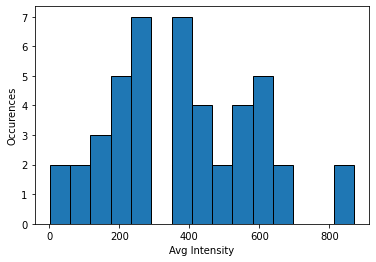

In [ ]:
plt.hist(labelareas,bins=15,edgecolor='black')
plt.xlabel('Avg Intensity')
plt.ylabel('Occurences')
plt.show()

Now we're back to a broad distribution as we expected, confirming that our heterogeneity in the sum was mostly because of size heterogeneity.

One thing to be aware of when measuring intensity is that the background may not be 0.  We can measure the average of the 0 label to see what our background is.  Make sure to measure the unfiltered labels so we don't include the edge objects in our background measurement.

In [ ]:
background=ndi.mean(img,labels,[0])[0]
background

56.931874985668756

So clearly our background is not 0 here and we would need to account for that in our measurements.  It's easy to replot the average intensties without the background. 

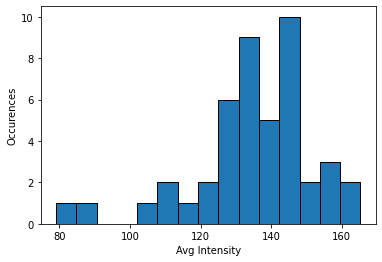

In [ ]:
plt.hist(labelavgs-background,bins=15,edgecolor='black')
plt.xlabel('Avg Intensity')
plt.ylabel('Occurences')
plt.show()

In [ ]:
#now let's load our fluorescent cells again and measure them

In [ ]:
cellsurl='https://github.com/jayunruh/python_IP_course/raw/master/FluorescentCells.tif'
#cellimg=tifffile.imread('FluorescentCells.tif')
cellimg=tifffile.imread(getGitHubImage(cellsurl))

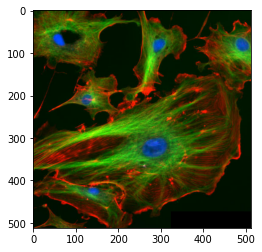

In [ ]:
plt.imshow(cellimg)

Background subtraction is tricky here but it is low for this image so let's assume it isn't significant.  Let's label and measure the nuclei.

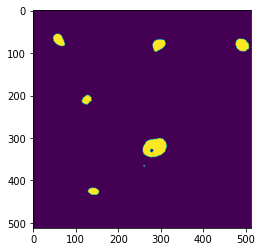

In [ ]:
plt.imshow(cellimg[:,:,2]>100)

In [ ]:
celllabels,ncells=ndi.label(cellimg[:,:,2]>100)
ncells

7

This label set needs some filtering.  We need to fill the hole in the the large nucleus and eliminate the small dot (labeled 6) next to that nucleus.  We can use the binary_fill_holes function but have to re-find the labels after that.

n cells: 6


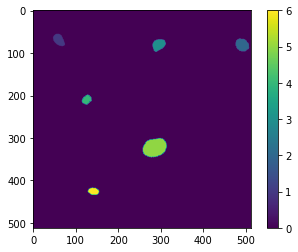

In [ ]:
celllabels[celllabels==6]=0.0
celllabels=ndi.binary_fill_holes(celllabels)
celllabels,ncells=ndi.label(celllabels>0)
print('n cells: '+str(ncells))
plt.imshow(celllabels)
plt.colorbar()
plt.show()

In [ ]:
#now we can measure in several channels at once
#use list comprehension to collect our results
cellmeans=[ndi.mean(cellimg[:,:,i],celllabels,range(1,ncells+1)) for i in range(3)]
cellmeans

[array([ 6.92446043, 19.72404372,  9.43213729, 61.21787709, 15.6574359 ,
        24.26035503]),
 array([69.76258993, 88.65300546, 88.00156006, 80.40502793, 69.8774359 ,
        86.09763314]),
 array([210.23920863, 151.32103825, 162.99531981, 119.46368715,
        143.7174359 , 163.56213018])]

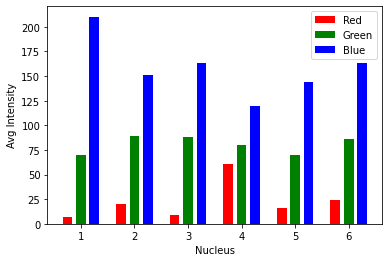

In [ ]:
xvals=np.arange(len(cellmeans[0]))+1
plt.bar(xvals-0.25,cellmeans[0],width=0.18,color='Red')
plt.bar(xvals,cellmeans[1],width=0.18,color='Green')
plt.bar(xvals+0.25,cellmeans[2],width=0.18,color='Blue')
plt.xticks(xvals)
plt.legend(['Red','Green','Blue'])
plt.xlabel('Nucleus')
plt.ylabel('Avg Intensity')
plt.show()

If we look closely at our image we can see that nucleus 4 has a red blob in it which corresponds with it's high intensity.

Now let's get into some bonus material.  Clearly the green signal in our image is excluded from the cell nucleus.  So our measurement doesn't really look at that space.  We could segment out the green regions but it each cell doesn't really have a centralized mass of that signal.  What if we could create a band around each nucleus that would measure that region?  We can do that with the ndimage maximum filter.

Let's talk a bit about filters.  Filters take a "kernel" (really just small pixel shape, often a 3 x 3 square) and place that kernel at each pixel in the image, replacing that pixel with a measurement over the kernel.  In our case, we can expand each nucleus by one pixel by using the maximum filter with a 3 x 3 kernel.  Each pixel will get replaced by the maximum signal in it's 3 x 3 neighborhood.  This operation is called "dilation".  If we dilate multiple times we can create a band around each nucleus to measure.

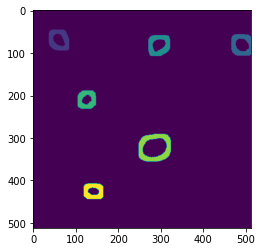

In [ ]:
bandthickness=10
bandlabels=celllabels.copy()
for i in range(bandthickness):
    bandlabels=ndi.maximum_filter(bandlabels,size=(3,3))
#now delete the original labels
bandlabels[celllabels>0]=0
plt.imshow(bandlabels)

That worked really well!  Let's see how those measurements look.

In [ ]:
bandmeans=[ndi.mean(cellimg[:,:,i],bandlabels,range(1,ncells+1)) for i in range(3)]
bandmeans

[array([38.04545455, 62.29313929, 54.3125    , 75.21725965, 40.66075113,
        71.02142857]),
 array([ 73.94025974, 127.23007623, 116.096875  , 103.09159727,
        102.66446554,  82.64285714]),
 array([22.86558442, 38.09494109, 27.78625   , 31.11960636, 39.34255056,
        32.53174603])]

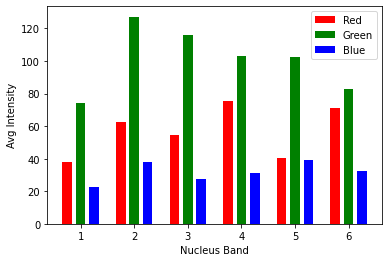

In [ ]:
xvals=np.arange(len(bandmeans[0]))+1
plt.bar(xvals-0.25,bandmeans[0],width=0.18,color='Red')
plt.bar(xvals,bandmeans[1],width=0.18,color='Green')
plt.bar(xvals+0.25,bandmeans[2],width=0.18,color='Blue')
plt.xticks(xvals)
plt.legend(['Red','Green','Blue'])
plt.xlabel('Nucleus Band')
plt.ylabel('Avg Intensity')
plt.show()

Now the green signals are much higher as expected.

We've only scratched the surface of filters.  The Gaussian filter can be used to smooth and blur signals.  How does that impact our blue nuclear channel:

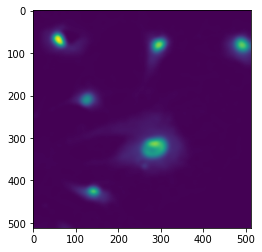

In [ ]:
plt.imshow(ndi.gaussian_filter(cellimg[:,:,2],sigma=5))

The Gaussian filter is really useful for smoothing out signal fluctuations that would make segmentation hard.  Sigma is the standard deviation of our Gaussian "kernel" so bigger values blur things more.  Previously we used the fill holes tool but the Gaussian filter would have made that unnecessary.  Another cool tool is the sobel filter.  Often people smooth the images before the sobel filter and calculate the squared sum of squares for the x and y directions.  This filter finds edge pixels by measuring the gradient around each pixel:

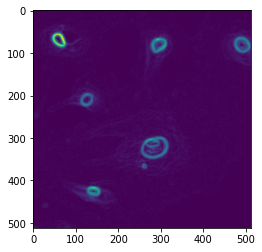

In [ ]:
smoothed=ndi.gaussian_filter(cellimg[:,:,2],sigma=2)
#for some reason sobel only get's calculated correctly in floating point type images
smoothed=smoothed.astype(float)
xgrad=ndi.sobel(smoothed,axis=0)
ygrad=ndi.sobel(smoothed,axis=1)
sobel=np.hypot(xgrad,ygrad).astype(float)
plt.imshow(sobel)

The sobel filter can be useful for finding and measuring edges of things.